<h1 style="text-align: center; font-family: Verdana; font-size: 32px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; font-variant: small-caps; letter-spacing: 3px; color: #468282; background-color: #ffffff;">HuBMAP + HPA - Hacking the Human Body</h1>
<h2 style="text-align: center; font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: underline; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;">Segment multi-organ functional tissue units</h2>

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/34547/logos/header.png"> 

> # 📌Introduction: 
>> A lot of segmentation competition is getting hosted in kaggle recently. This competition is very similar to the previous segmentation competitions, eg: [Sartorius CIS](https://www.kaggle.com/competitions/sartorius-cell-instance-segmentation/overview), and ongoing [UW-Madison GI Tract Image Segmentation](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation) also felt similar [but no so much], from the POV of medical data, segmentation problem statement. You might start with different models used in those above competitions, and learn a few frameworks used like MMdet, detectron2 etc. The evaluation metric is mean Dice coefficient, don't really know why mean?[maybe because mean over all the segments found in a single image]. But other than that Dice coefficient is a very popular metric for image segmentation. if you don't know, you might want to check out this [NB](https://www.kaggle.com/code/yerramvarun/understanding-dice-coefficient). Use models like Unet, SegNet, Enet etc. type encoder decoder model for baseline, then move on to more complex models and pre-processing and post-processing techniques. Follow the augmentations used in the previous competitions, and do trial and error for fitting those augmentations to the model, or come up with some new one. 

>> Data for this competition comes from two different consortiums, the Human Protein Atlas (HPA) and Human BioMolecular Atlas Program (HUBMAP). As mentioned in the Data tab, one of the main challenges of this competition will be adapting models to function properly when presented with data collected using a different protocol. Because among the three datasets, the training set contains data from public HPAs, the public test set is a combination of private HPAs and HuBMAP data, and the private test set contains only HuBMAP data. Image resolution is high, though the number of training images are very small(351).

>> I plan to publish three different parts which will include data prep, model training, model inference. Its a very basic version of the NB, will try to improve over time.

# Imports

In [1]:
# !pip3 install -q tifffile

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import random
# from tifffile import imread

In [7]:
DIR = "../hubmap_data/hubmap-organ-segmentation"
train_df = pd.read_csv(os.path.join(DIR,"train.csv"))
train_df.head()

id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   
2                 4  1228631 20 1231629 24 1234624 40 1237623 47 12...  82.0   
3                 4  3446519 15 3449517 17 3452514 20 3455510 24 34...  78.0   
4                 4  478925 68 481909 87 484893 105 487863 154 4908...  21.0   

      sex  
0    Male  
1    Male  
2    Male  
3    Male  
4  Female

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                351 non-null    int64  
 1   organ             351 non-null    object 
 2   data_source       351 non-null    object 
 3   img_height        351 non-null    int64  
 4   img_width         351 non-null    int64  
 5   pixel_size        351 non-null    float64
 6   tissue_thickness  351 non-null    int64  
 7   rle               351 non-null    object 
 8   age               351 non-null    float64
 9   sex               351 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 27.5+ KB


<AxesSubplot:>

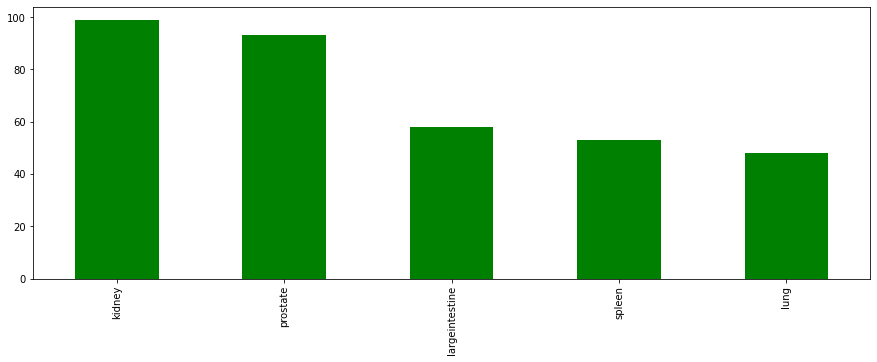

In [9]:
plt.figure(figsize=(15,5))
train_df["organ"].value_counts().plot(kind='bar', color='green')

In [10]:
# source: https://www.kaggle.com/code/julian3833/sartorius-starter-torch-mask-r-cnn-lb-0-273 w/ a bit change
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape).T

In [17]:
train_df[train_df["id"]==28963]

id   organ data_source  img_height  img_width  pixel_size  \
215  28963  spleen         HPA        2511       2511         0.4   

     tissue_thickness                                                rle  \
215                 4  3651527 60 3654034 66 3656445 171 3658955 174 ...   

      age     sex  
215  70.0  Female

# Checking the training data:

[  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26
  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245]


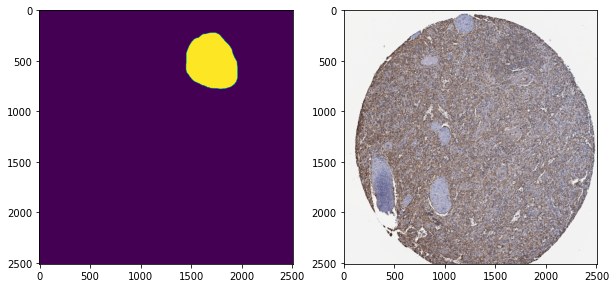

In [18]:
img_dir = os.path.join("../hubmap_data/hubmap-organ-segmentation/train_images" , str(train_df["id"].iloc[215]) + '.tiff')
img = plt.imread(img_dir)
rle_img = rle_decode(train_df["rle"].iloc[215],(train_df["img_height"].iloc[215],train_df["img_width"].iloc[215]))

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(rle_img)


plt.subplot(1,2,2)
plt.imshow(img)
print(np.unique(img))

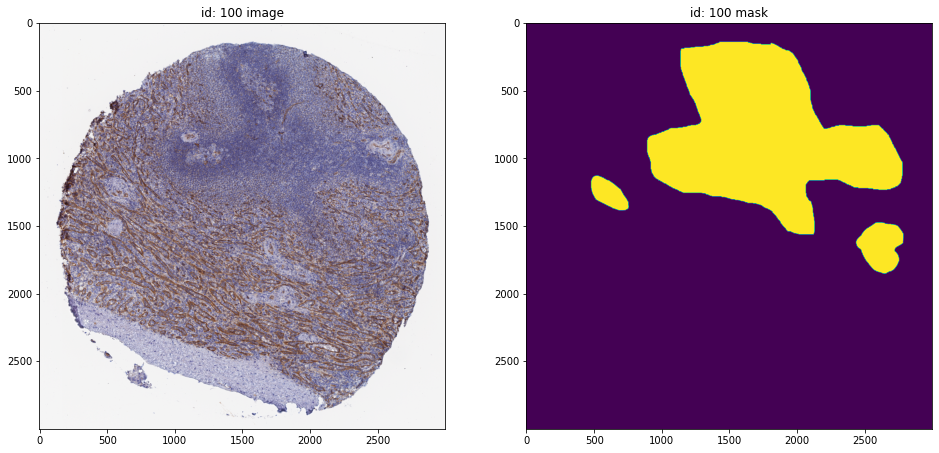

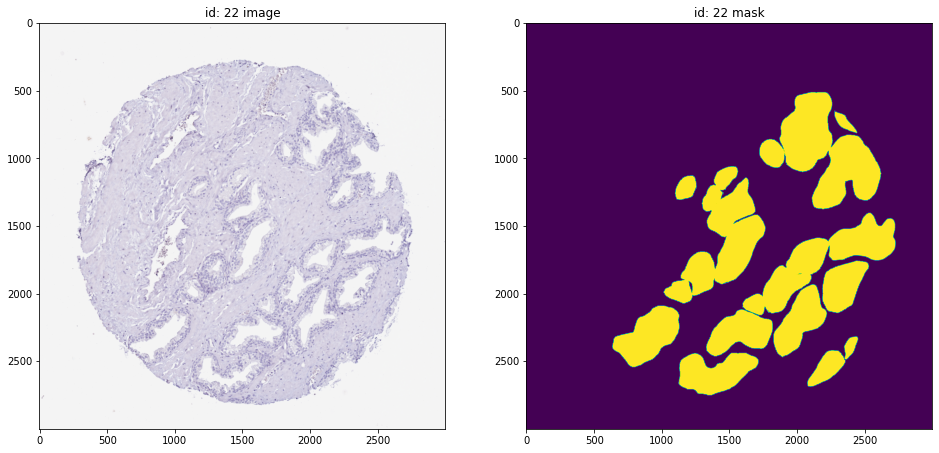

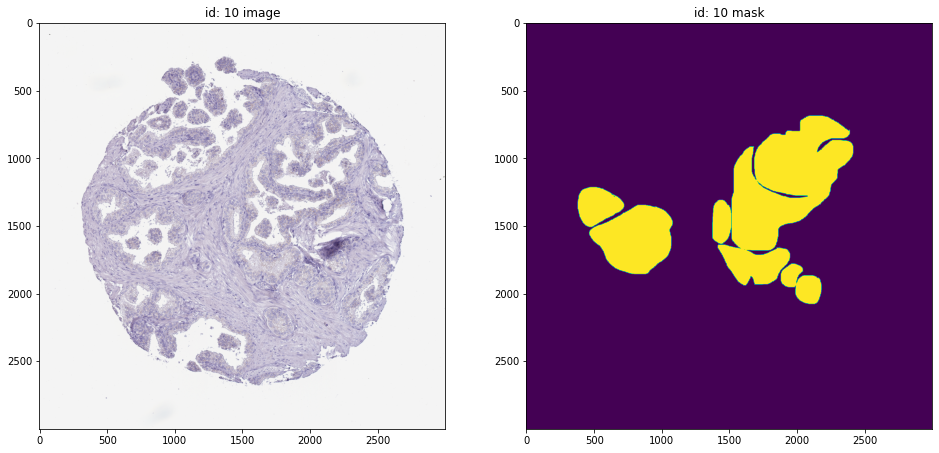

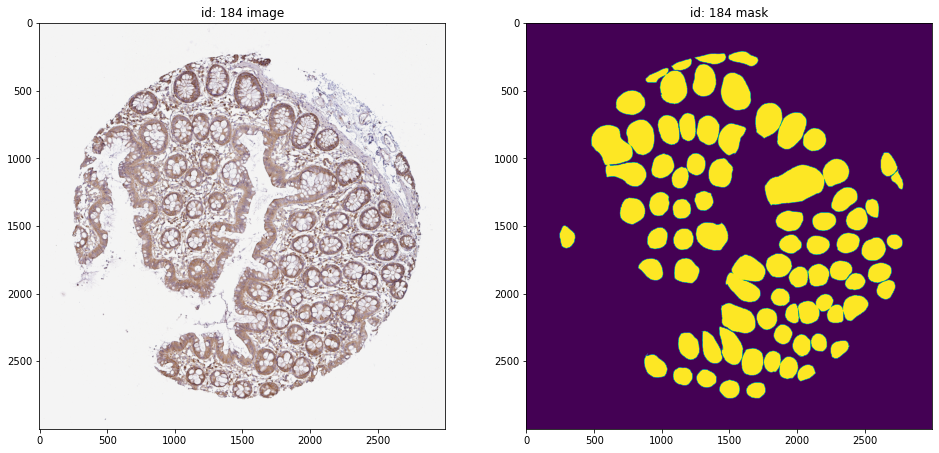

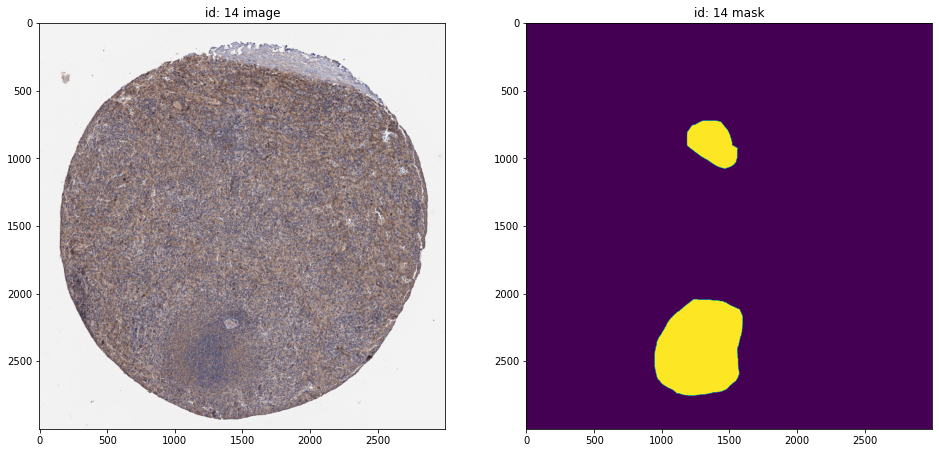

In [15]:
# train_df["rle"].iloc[0]

for i in np.random.choice(200,5):
    rle_img = rle_decode(train_df["rle"].iloc[i],(train_df["img_height"].iloc[i],train_df["img_width"].iloc[i]))
    img_dir = os.path.join("./hubmap_data/hubmap-organ-segmentation/train_images" , str(train_df["id"].iloc[i]) + '.tiff')
#     print(img_dir)
    img = plt.imread(img_dir)

    plt.figure(figsize=(16,18))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"id: {i} image")

    plt.subplot(1,2,2)
    plt.imshow(rle_img)
    plt.title(f"id: {i} mask");

# Comparing `train_annotations` folder data with RLE: 

- Reading the RLE from `.csv` and creating the mask.

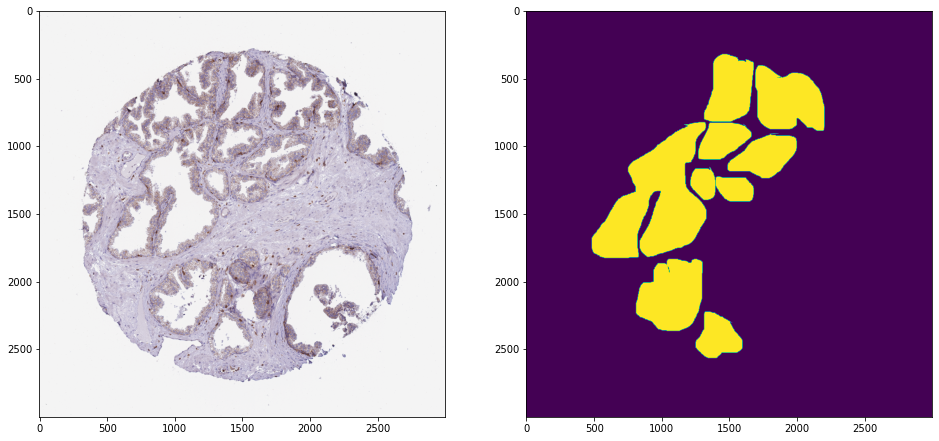

In [17]:
i = 0
rle_img = rle_decode(train_df["rle"].iloc[i],(train_df["img_height"].iloc[i],train_df["img_width"].iloc[i]))
img_dir = os.path.join("./hubmap_data/hubmap-organ-segmentation/train_images" , str(train_df["id"].iloc[i]) + '.tiff')
#     print(img_dir)
img = plt.imread(img_dir)

plt.figure(figsize=(16,18))
plt.subplot(1,2,1)
plt.imshow(img)

plt.subplot(1,2,2)
plt.imshow(rle_img);

- Reading the polygon ploints from json.

In [18]:
with open("./hubmap_data/hubmap-organ-segmentation/train_annotations/10044.json") as rle_json:
    data = json.load(rle_json)
    
print(data.__len__())

9


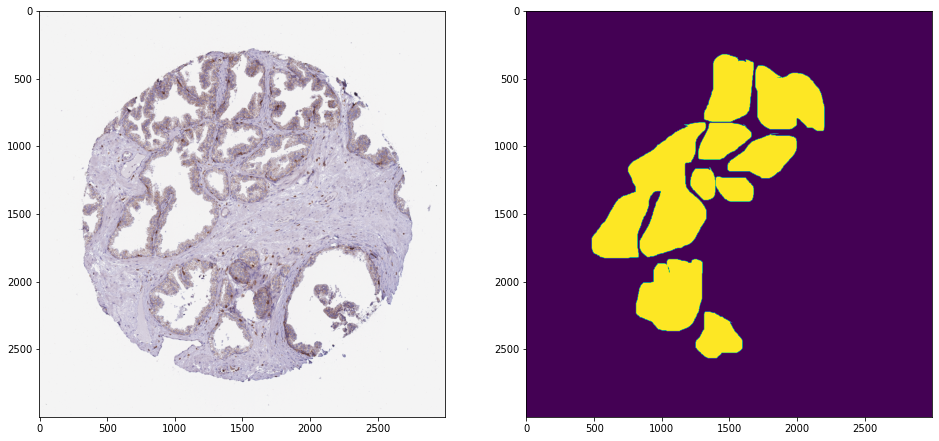

In [19]:
image = np.zeros((3000,3000))
for i in range(len(data)):
    image = cv2.fillPoly(image, pts = [np.array(data[i])], color =(255,255,255))

plt.figure(figsize=(16,18))
plt.subplot(1,2,1)
plt.imshow(img)

plt.subplot(1,2,2)
plt.imshow(image);

- Both are same

## Overlay of Mask for Different Class:

In [20]:
folder1 = "./hubmap_data/train_masks"
folder2 = "./hubmap_data/train_masks_np"

if not os.path.isdir(folder1):
    os.mkdir(folder1)
    
if not os.path.isdir(folder2):
    os.mkdir(folder2)
    
    
for i in tqdm(range(len(train_df))):
    rle_img = rle_decode(train_df["rle"].iloc[i],(train_df["img_height"].iloc[i],train_df["img_width"].iloc[i]))
    f_name1 = os.path.join(folder1, str(train_df["id"].iloc[i])+'.png')
    f_name2 = os.path.join(folder2, str(train_df["id"].iloc[i])+'.npy')

    cv2.imwrite(f_name1,rle_img)
    np.save(f_name2, rle_img)
    

100%|██████████| 351/351 [01:13<00:00,  4.75it/s]


# Saving the masks in folder:

In [21]:
TRAIN_DIR = DIR + "/train_images/"
func = lambda x: TRAIN_DIR + str(x) + ".tiff"
train_df["img_path"] = train_df["id"].apply(func)
train_df.head()

id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   
2                 4  1228631 20 1231629 24 1234624 40 1237623 47 12...  82.0   
3                 4  3446519 15 3449517 17 3452514 20 3455510 24 34...  78.0   
4                 4  478925 68 481909 87 484893 105 487863 154 4908...  21.0   

      sex                                           img_path  
0    Male  ./hubmap_data/hubmap-organ-segmentation/train_...  
1    Male  ./hubmap_data/hubmap-organ-segmentation/train_...  
2    Male  ./hubmap_data/hubmap-organ-segmentation/train_...  
3    Male  ./hubmap_data/hubmap-organ-segmentation/train_...  
4  Female  ./hubmap_data/hubmap-organ-segmentation/train_...

In [24]:
kidney_files = random.choices(train_df[train_df["organ"]=='kidney']['img_path'].to_list(),k=1)
prostate_files = random.choices(train_df[train_df["organ"]=='prostate']['img_path'].to_list(),k=1)
largeint_files = random.choices(train_df[train_df["organ"]=='largeintestine']['img_path'].to_list(),k=1)
splieen_files = random.choices(train_df[train_df["organ"]=='spleen']['img_path'].to_list(),k=1)
lung_files = random.choices(train_df[train_df["organ"]=='lung']['img_path'].to_list(),k=1)

organ_list = np.unique(train_df["organ"]).tolist()
main_list = [kidney_files,prostate_files, largeint_files, splieen_files, lung_files,]

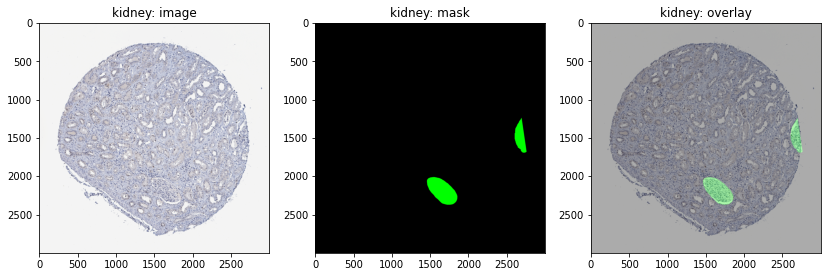

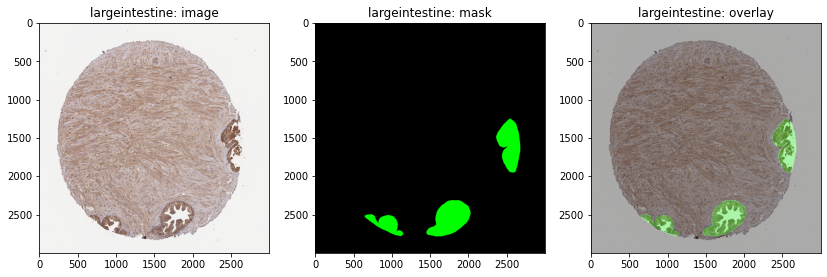

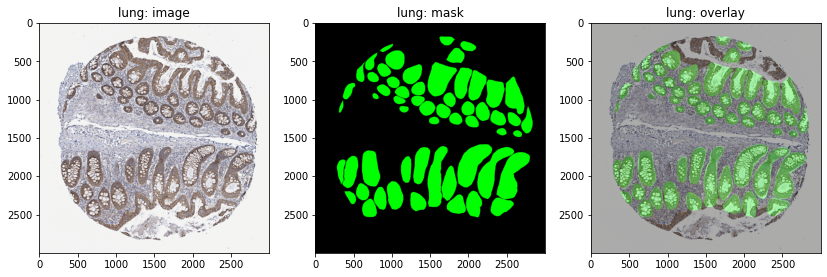

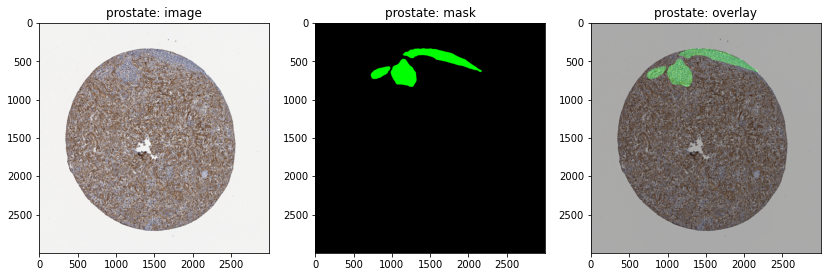

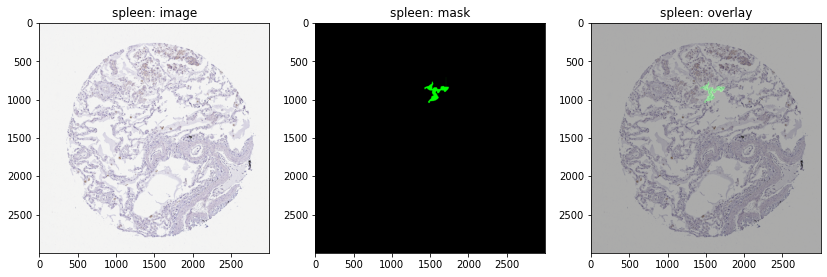

In [26]:
# lung_files[0].split('/')[-1].split('.')[0]
MASK_DIR = "./hubmap_data/train_masks_np/"

for i in range(5):
#     print(main_list[i][0])
    img = cv2.resize(plt.imread(main_list[i][0]),(3000,3000))
    mask_file = MASK_DIR + main_list[i][0].split('/')[-1].split('.')[0]+'.npy'
#     print(mask_file)
    mask = np.resize(np.load(mask_file),(3000,3000))
    mask = mask.reshape(mask.shape[0],mask.shape[1],1)
    zero_mask = np.zeros((3000,3000,3))

    zero_mask[:,:,0] = mask[:,:,0]
    zero_mask[:,:,1] = mask[:,:,0]
    zero_mask[:,:,2] = mask[:,:,0]
    
    zero_mask[:,:,0] = zero_mask[:,:,0] * 0
    zero_mask[:,:,1] = zero_mask[:,:,1] * 255 
    zero_mask[:,:,2] = zero_mask[:,:,2] * 0 

    zero_mask = zero_mask.astype(np.uint8)
    
    combo = cv2.addWeighted(img, 0.7, zero_mask, 0.3, 0.0)
    
    plt.figure(figsize=(14,16))
    
    ax1 = plt.subplot(1,3,1)
    plt.imshow(img)
    ax1.set_title(f"{organ_list[i]}: image")
    
    
    ax2 = plt.subplot(1,3,2)
    plt.imshow(zero_mask)
    ax2.set_title(f"{organ_list[i]}: mask")
    
    ax3 = plt.subplot(1,3,3)
    plt.imshow(combo)
    ax3.set_title(f"{organ_list[i]}: overlay")
    
    plt.show()
#     break

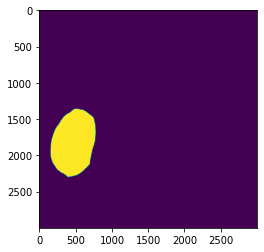

In [27]:
plt.imshow(np.load(os.path.join(folder2,"10610.npy")))

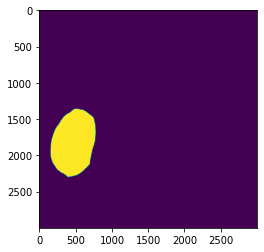

In [28]:
plt.imshow(plt.imread(os.path.join(folder1,"10610.png")))

In [30]:
os.listdir("./hubmap_data/train_masks_np").__len__(), os.listdir("./hubmap_data/train_masks").__len__()

(351, 351)

> # ⭕ WORK IN PROGRESS ! ! !
<p align="center">
<img src="https://media.giphy.com/media/xThuWu82QD3pj4wvEQ/giphy.gif" width="300">
</p>